In [1]:
import numpy as np
from glob import glob
import os
import healpy as hp

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpec
import seaborn as sns
import logging

from src.utils.ConfigData import ConfigAnalysis, ConfigData
from src.utils.compute_sigma import parse_file_name
from src.flatsky.analysis_patch_flatsky import WeakLensingAnalysis, WeakLensingCovariance

logging.basicConfig(level=logging.ERROR)

In [2]:
config_analysis_path = "/lustre/work/akira.tokiwa/Projects/LensingSSC/configs/config_analysis.json"
config_analysis = ConfigAnalysis.from_json(config_analysis_path)

config_data_path = "/lustre/work/akira.tokiwa/Projects/LensingSSC/configs/config_data.json"
config_data = ConfigData.from_json(config_data_path)

zs_list = config_data.zs_list
sl_list = config_analysis.sl_arcmin

In [3]:
# load data, (zs, sl, survey)
stddev_bigbox = np.load("/lustre/work/akira.tokiwa/Projects/LensingSSC/results/bigbox/stddev_dict.pkl", allow_pickle=True)
stddev_tiled = np.load("/lustre/work/akira.tokiwa/Projects/LensingSSC/results/tiled/stddev_dict.pkl", allow_pickle=True)


FileNotFoundError: [Errno 2] No such file or directory: '/lustre/work/akira.tokiwa/Projects/LensingSSC/results/tiled/stddev_dict.pkl'

# Data Loading

In [4]:
config_analysis_path = "/lustre/work/akira.tokiwa/Projects/LensingSSC/configs/config_analysis.json"
config_analysis = ConfigAnalysis.from_json(config_analysis_path)

data_paths_bigbox = glob(f"{config_analysis.resultsdir}/bigbox/data/kappa_zs*.fits")
data_paths_tiled = glob(f"{config_analysis.resultsdir}/tiled/data/kappa_zs*.fits")

data_paths_bigbox_smoothed = glob(f"{config_analysis.resultsdir}/bigbox/smoothed/sl=*/kappa_zs*.fits")
data_paths_tiled_smoothed = glob(f"{config_analysis.resultsdir}/tiled/smoothed/sl=*/kappa_zs*.fits")

dir_results_bigbox = os.path.join(config_analysis.resultsdir, "bigbox")
dir_results_tiled = os.path.join(config_analysis.resultsdir, "tiled")

In [5]:
def dir_from_path(dir_results, data_path):
    source_redshift, smoothing_length, survey = parse_file_name(data_path)
    if smoothing_length is None:
        dir_cov = os.path.join(dir_results, f"zs{source_redshift:.1f}", "patch_flat")
    elif survey is None:
        dir_cov = os.path.join(dir_results, f"zs{source_redshift:.1f}", f"sl{smoothing_length}", "patch_flat")
    else:
        dir_cov = os.path.join(dir_results, f"zs{source_redshift:.1f}", f"sl{smoothing_length}", f"{survey}", "patch_flat")

    return dir_cov

def load_covariance(dir_results, data_path):
    dir_cov = dir_from_path(dir_results, data_path)
    data_cov = np.load(os.path.join(dir_cov, "covariance", "cov_full.npz"))
    return data_cov["cov_full"], data_cov["correlation"], data_cov["diagonal_terms"]

In [6]:
def check_in_list(path, source_redshift, smoothing_length, survey):
    source_redshift_path, smoothing_length_path, survey_path = parse_file_name(path)
    flag1 = True if source_redshift is None else source_redshift_path in source_redshift
    flag2 = smoothing_length_path is None if smoothing_length is None else smoothing_length_path in smoothing_length
    flag3 = survey_path is None if survey is None else survey_path in survey
    return flag1 and flag2 and flag3

def select_data(data_paths, source_redshift=None, smoothing_length=None, survey=None):
    # select data paths, if not specified, return all
    if source_redshift == "all":
        source_redshift = zs_list
    if smoothing_length == "all":
        smoothing_length = sl_list
    if survey == "all":
        survey = ["DES-KiDS", "HSC", "Euclid-LSST", "Roman"]

    if type(source_redshift) is float:
        source_redshift = [source_redshift]
    if type(smoothing_length) is int:
        smoothing_length = [smoothing_length]
    if type(survey) is str:
        survey = [survey]

    data_paths_selected = [data_path for data_path in data_paths if check_in_list(data_path, source_redshift, smoothing_length, survey)]

    return sorted(data_paths_selected)

## Full covariance

In [7]:
sl = 5

data_mean_bigbox = []
data_std_bigbox = []
cov_full_bigbox = []
correlation_bigbox = []
diagonal_terms_bigbox = []

bins_bigbox = []

for zs in zs_list:
    data_path_smoothed = select_data(data_paths_bigbox_smoothed, source_redshift=zs, smoothing_length=sl)[0]
    data_path = select_data(data_paths_bigbox, source_redshift=zs)[0]
    print(f"zs={zs}, sl={sl}")

    dir_data = dir_from_path(dir_results_bigbox, data_path)
    wl = WeakLensingCovariance(dir_data, save=False)
    ell, clkks, _, _, _ = wl.cov_clkk()
    _, equilateral, halfed, squeezed, _, _, _, _, _, _, _, _, _ = wl.cov_bispectrum()
    nu, pdfs, _, _, _ = wl.cov_pdf()

    dir_data = dir_from_path(dir_results_bigbox, data_path_smoothed)
    wl = WeakLensingCovariance(dir_data, save=False)
    bins, peaks, _, _, _ = wl.cov_peaks()
    bins = (bins[1:] + bins[:-1]) / 2
    _, minima, _, _, _ = wl.cov_minima()

    data_full = np.hstack([clkks*ell**2/(2*np.pi), peaks, minima, pdfs, equilateral*ell**4/(2*np.pi)**2, halfed*ell**4/(2*np.pi)**2, squeezed*ell**4/(2*np.pi)**2])
    cov_full = np.cov(data_full, rowvar=False)
    diagonal_terms = np.diag(cov_full)
    
    correlation = np.nan_to_num(cov_full / np.sqrt(diagonal_terms[:, None] * diagonal_terms[None, :]))

    data_mean_bigbox.append(np.mean(data_full, axis=0))
    data_std_bigbox.append(np.std(data_full, axis=0))
    cov_full_bigbox.append(cov_full)
    correlation_bigbox.append(correlation)
    diagonal_terms_bigbox.append(diagonal_terms)

    bins_bigbox.append(np.hstack([ell, bins, bins, nu, ell, ell, ell]))

zs=0.5, sl=5


IndexError: list index out of range

In [8]:
data_mean_tiled = []
data_std_tiled = []
cov_full_tiled = []
correlation_tiled = []
diagonal_terms_tiled = []

bins_tiled = []

for zs in zs_list:
    data_path_smoothed = select_data(data_paths_tiled_smoothed, source_redshift=zs, smoothing_length=sl)[0]
    data_path = select_data(data_paths_tiled, source_redshift=zs)[0]
    print(f"zs={zs}, sl={sl}")

    dir_data = dir_from_path(dir_results_tiled, data_path)
    wl = WeakLensingCovariance(dir_data, save=False)
    ell, clkks, _, _, _ = wl.cov_clkk()
    _, equilateral, halfed, squeezed, _, _, _, _, _, _, _, _, _ = wl.cov_bispectrum()
    nu, pdfs, _, _, _ = wl.cov_pdf()

    dir_data = dir_from_path(dir_results_tiled, data_path_smoothed)
    wl = WeakLensingCovariance(dir_data, save=False)
    bins, peaks, _, _, _ = wl.cov_peaks()
    bins = (bins[1:] + bins[:-1]) / 2
    _, minima, _, _, _ = wl.cov_minima()

    data_full = np.hstack([clkks*ell**2/(2*np.pi), peaks, minima, pdfs, equilateral*ell**4/(2*np.pi)**2, halfed*ell**4/(2*np.pi)**2, squeezed*ell**4/(2*np.pi)**2])
    cov_full = np.cov(data_full, rowvar=False)
    diagonal_terms = np.diag(cov_full)
    
    correlation = np.nan_to_num(cov_full / np.sqrt(diagonal_terms[:, None] * diagonal_terms[None, :]))

    data_mean_tiled.append(np.mean(data_full, axis=0))
    data_std_tiled.append(np.std(data_full, axis=0))
    cov_full_tiled.append(cov_full)
    correlation_tiled.append(correlation)
    diagonal_terms_tiled.append(diagonal_terms)

    bins_tiled.append(np.hstack([ell, bins, bins, nu, ell, ell, ell]))

zs=0.5, sl=5


/var/tmp/pbs.268328.idark/ipykernel_170101/868996990.py:30: RuntimeWarning: invalid value encountered in true_divide
  correlation = np.nan_to_num(cov_full / np.sqrt(diagonal_terms[:, None] * diagonal_terms[None, :]))


zs=1.0, sl=5
zs=1.5, sl=5
zs=2.0, sl=5


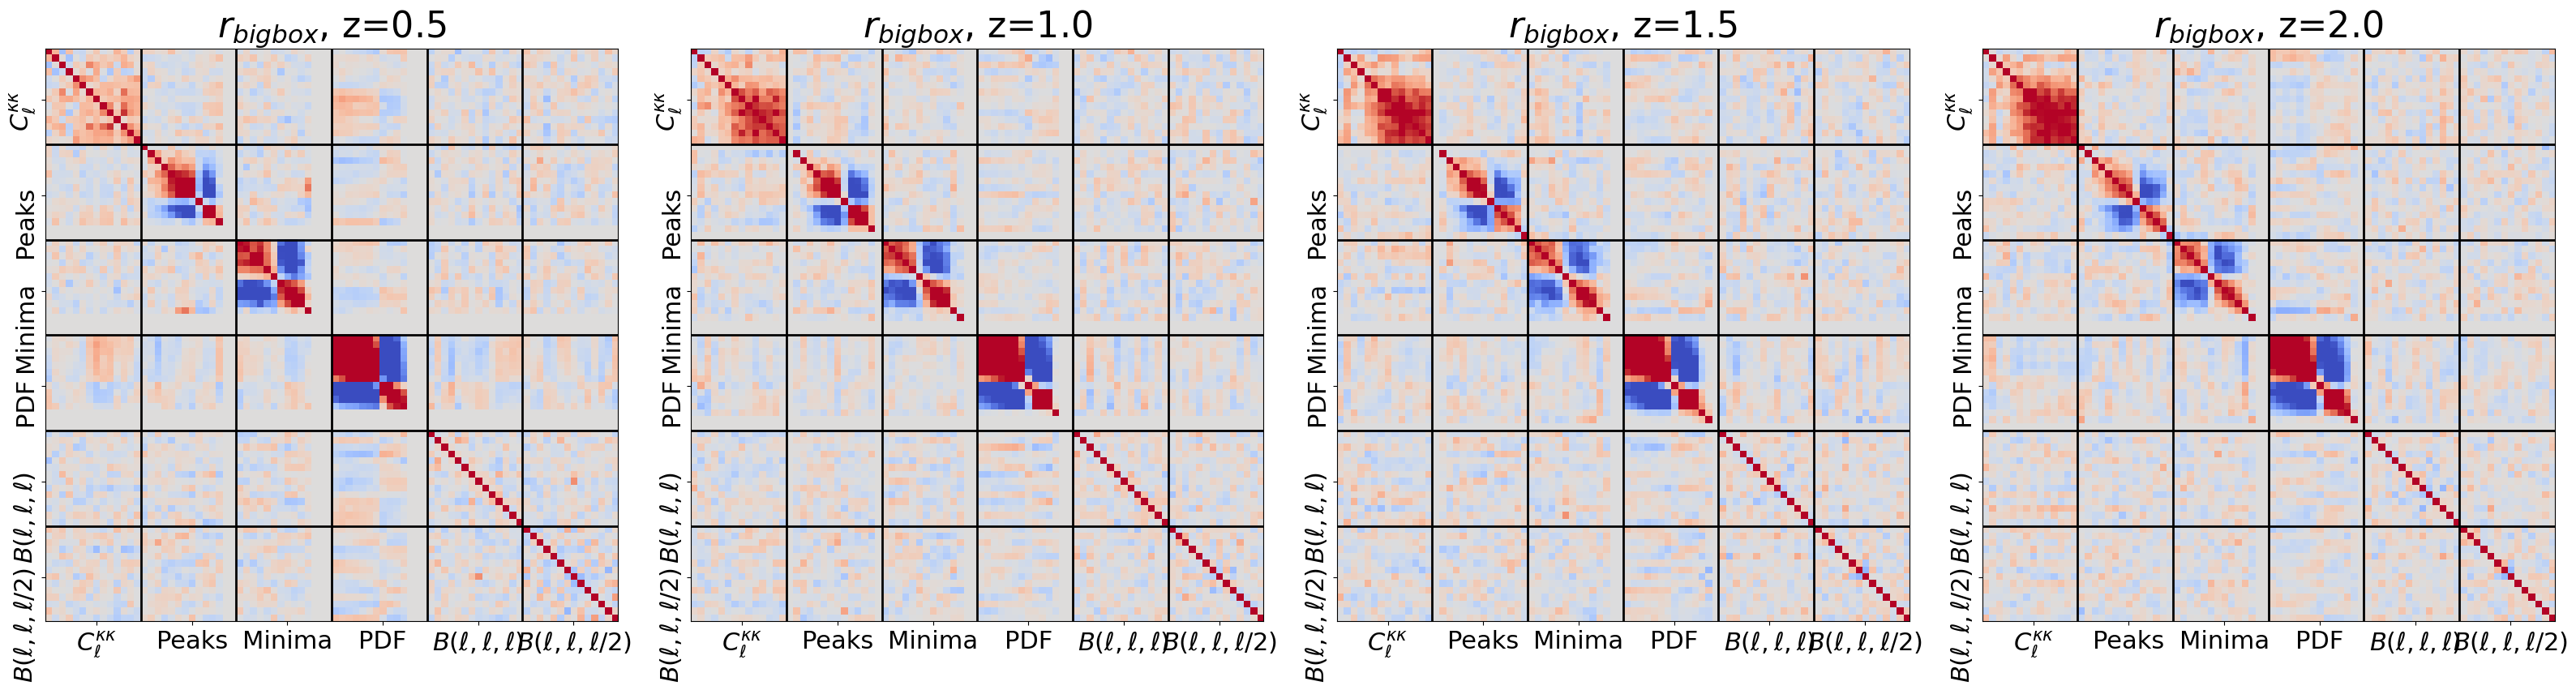

In [27]:
# Define the labels for each statistics block
labels = [r'$C^{\kappa\kappa}_{\ell}$', 
          "Peaks",
          "Minima",
          "PDF",
          r'$B(\ell, \ell, \ell)$', 
          r'$B(\ell, \ell, \ell/2)$']

# Create the plot
fig, axes = plt.subplots(1, 4, figsize=(32, 8))

for idx, ax in enumerate(axes.flat):
    matrix = np.nan_to_num(correlation_bigbox[idx][:-14, :-14])

    im = ax.imshow(matrix, cmap='coolwarm', vmin=-0.5, vmax=0.5)

    tick_positions = [7 + 14 * i for i in range(len(labels))]  # Center positions of each 14x14 block

    ax.set_title(r"$r_{bigbox}$"+f", z={zs_list[idx]}", fontsize=32)

    ax.set_xticks(tick_positions)
    ax.set_yticks(tick_positions)
    ax.set_xticklabels(labels, fontsize=22)
    ax.set_yticklabels(labels, fontsize=22, rotation=90, ha='right')


    # Add grid lines to separate statistics
    for i in range(1, len(labels)):
        ax.axhline(y=i * 14 - 0.5, color='black', linewidth=2)
        ax.axvline(x=i * 14 - 0.5, color='black', linewidth=2)

# Show the plot
plt.tight_layout()
plt.show()

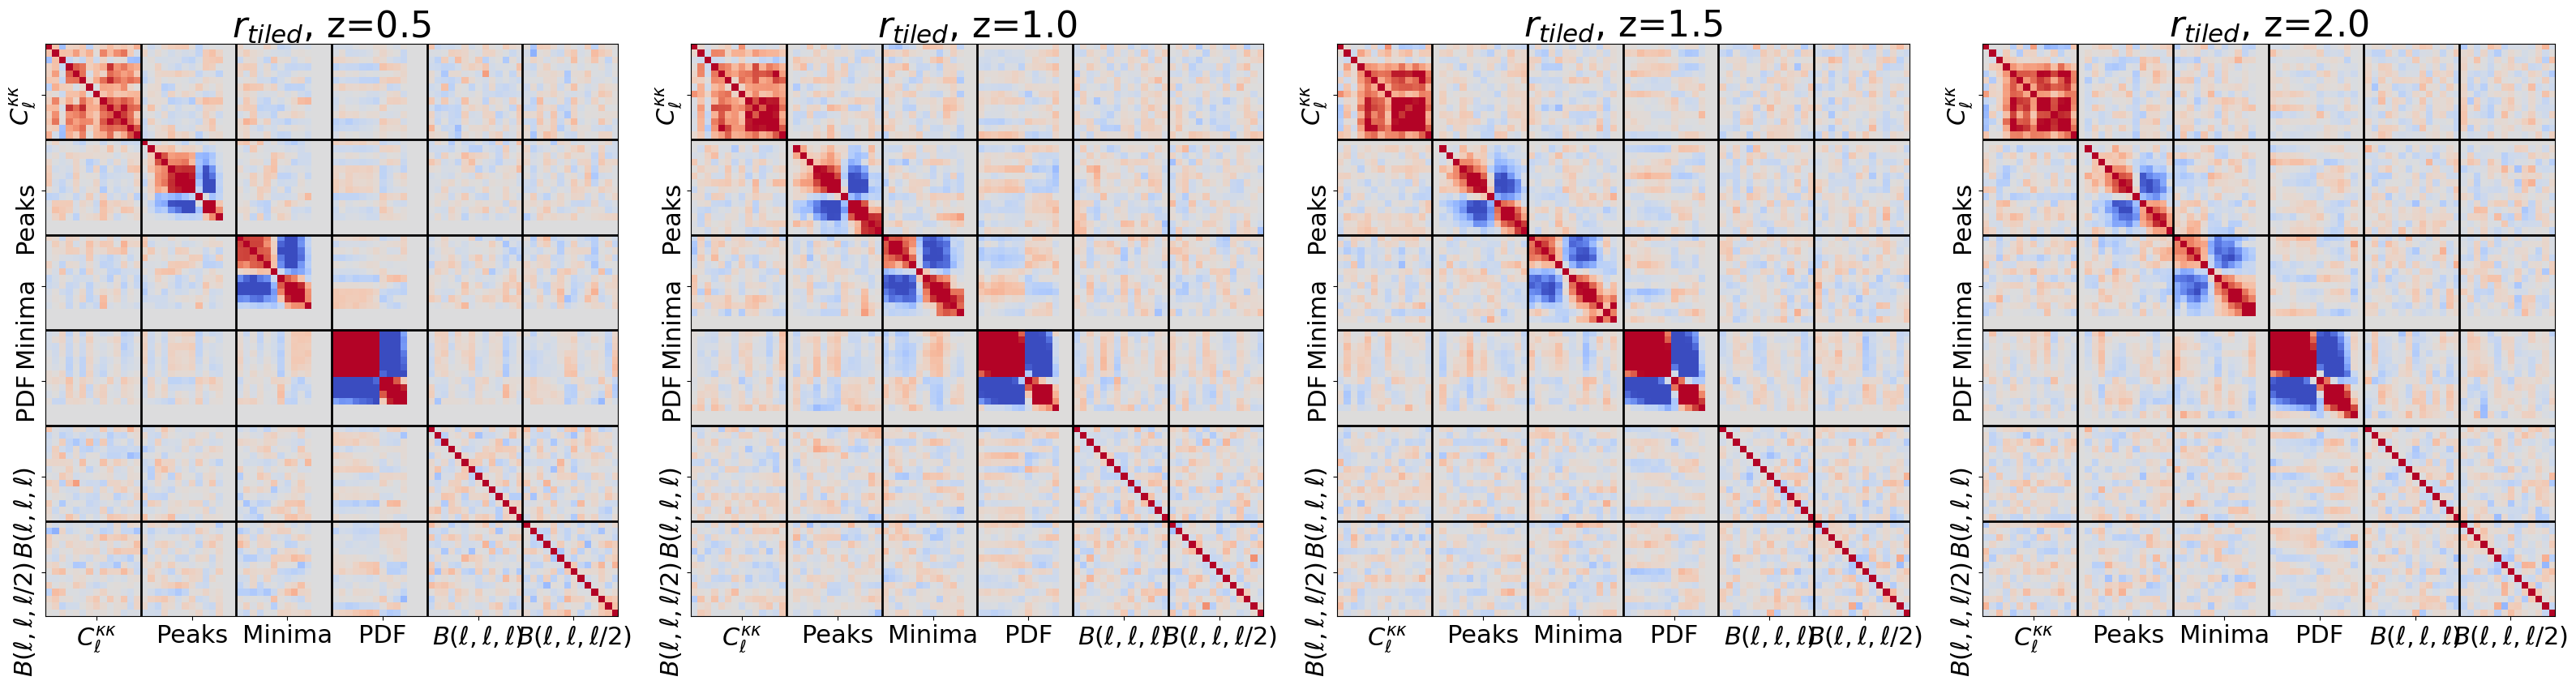

In [29]:
# Define the labels for each statistics block
labels = [r'$C^{\kappa\kappa}_{\ell}$', 
          "Peaks",
          "Minima",
          "PDF",
          r'$B(\ell, \ell, \ell)$', 
          r'$B(\ell, \ell, \ell/2)$']

# Create the plot
fig, axes = plt.subplots(1, 4, figsize=(32, 8))

for idx, ax in enumerate(axes.flat):
    matrix = np.nan_to_num(correlation_tiled[idx][:-14, :-14])

    im = ax.imshow(matrix, cmap='coolwarm', vmin=-0.5, vmax=0.5)

    tick_positions = [7 + 14 * i for i in range(len(labels))]  # Center positions of each 14x14 block

    ax.set_title(r"$r_{tiled}$"+f", z={zs_list[idx]}", fontsize=32)

    ax.set_xticks(tick_positions)
    ax.set_yticks(tick_positions)
    ax.set_xticklabels(labels, fontsize=22)
    ax.set_yticklabels(labels, fontsize=22, rotation=90, ha='right')


    # Add grid lines to separate statistics
    for i in range(1, len(labels)):
        ax.axhline(y=i * 14 - 0.5, color='black', linewidth=2)
        ax.axvline(x=i * 14 - 0.5, color='black', linewidth=2)

# Show the plot
plt.tight_layout()
plt.show()

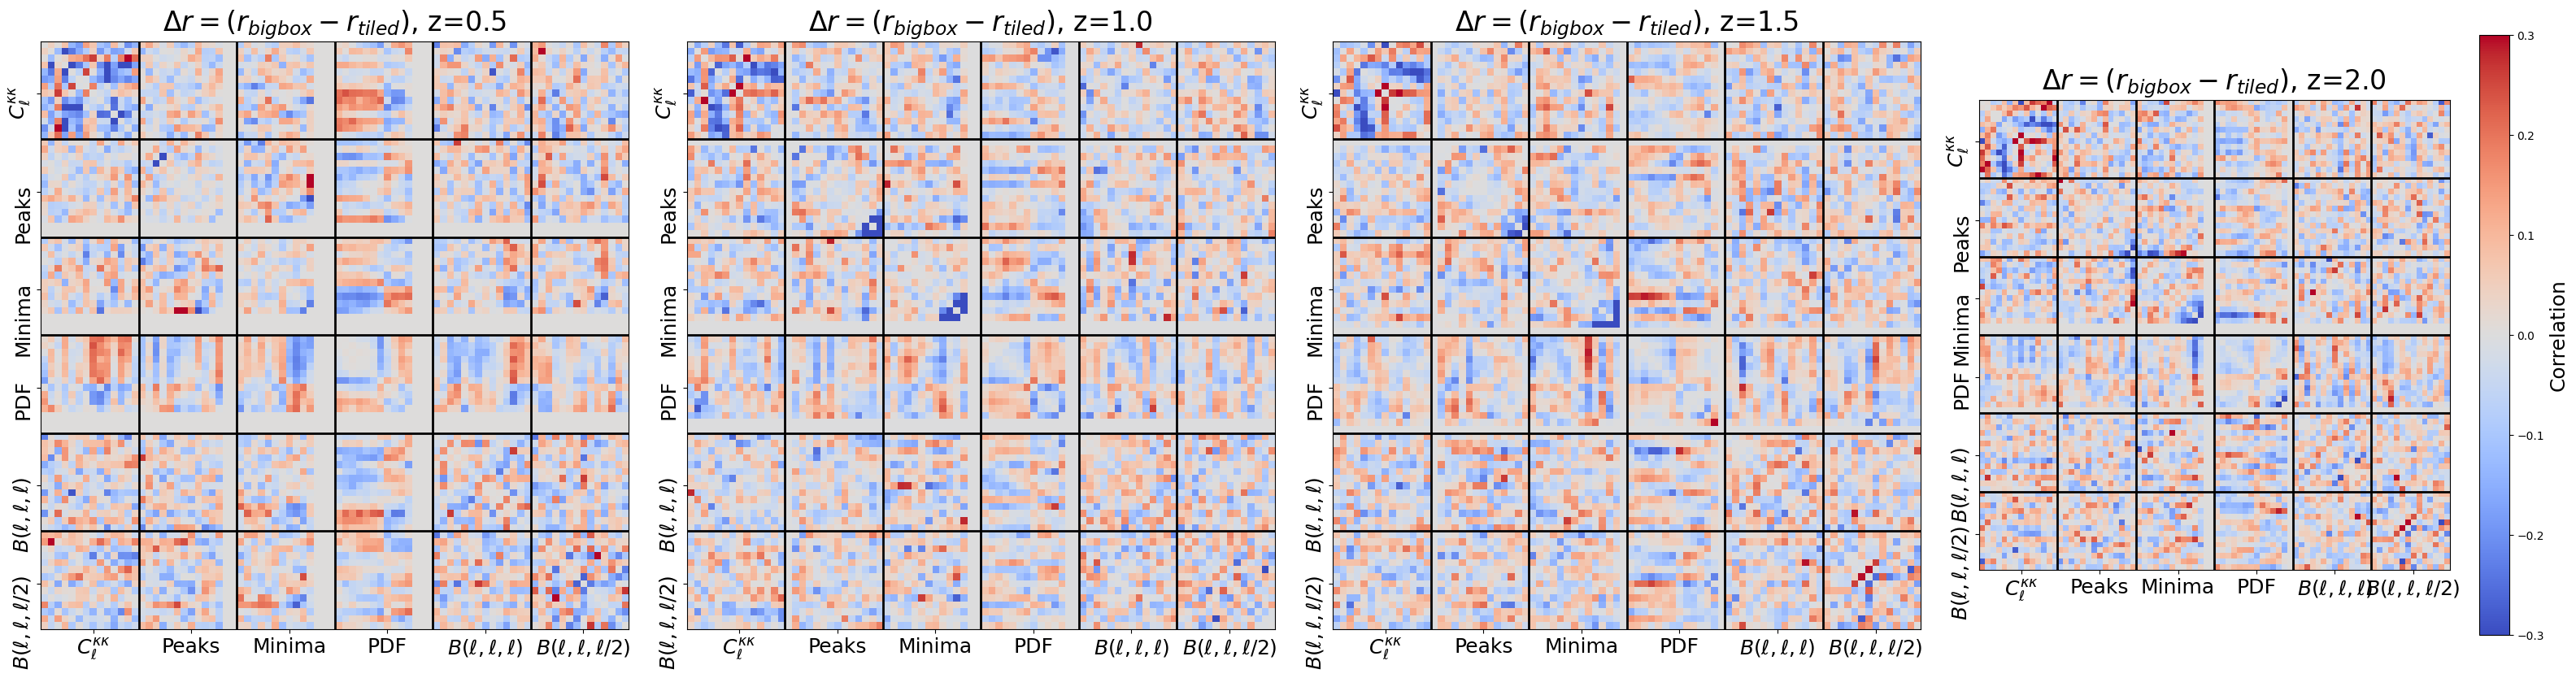

In [16]:
# Define the labels for each statistics block
labels = [r'$C^{\kappa\kappa}_{\ell}$', 
          "Peaks",
          "Minima",
          "PDF",
          r'$B(\ell, \ell, \ell)$', 
          r'$B(\ell, \ell, \ell/2)$']
          #r'$B(\ell, \ell, \sim0)$']

# Create the plot
fig, axes = plt.subplots(1, 4, figsize=(32, 8))

for idx, ax in enumerate(axes.flat):
    matrix = np.nan_to_num(correlation_bigbox[idx] - correlation_tiled[idx])[:-14, :-14]

    im = ax.imshow(matrix, cmap='coolwarm', vmin=-0.3, vmax=0.3)

    tick_positions = [7 + 14 * i for i in range(len(labels))]  # Center positions of each 14x14 block

    ax.set_title(r"$\Delta r = (r_{bigbox} - r_{tiled})$"+f", z={zs_list[idx]}", fontsize=24)

    ax.set_xticks(tick_positions)
    ax.set_yticks(tick_positions)
    ax.set_xticklabels(labels, fontsize=18)
    ax.set_yticklabels(labels, fontsize=18, rotation=90, ha='right')


    # Add grid lines to separate statistics
    for i in range(1, len(labels)):
        ax.axhline(y=i * 14 - 0.5, color='black', linewidth=2)
        ax.axvline(x=i * 14 - 0.5, color='black', linewidth=2)

cbar = fig.colorbar(im, ax=axes[3], pad=0.05)
cbar.set_label('Correlation', fontsize=18)


# Show the plot
plt.tight_layout()
plt.show()

## Plot smoothingless data

/var/tmp/pbs.268328.idark/ipykernel_170101/1252309827.py:35: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(bins_bigbox[j][i*binsize:(i+1)*binsize], np.abs(data_mean_bigbox[j][i*binsize:(i+1)*binsize])/np.abs(data_mean_tiled[j][i*binsize:(i+1)*binsize]), color=colors[zs], label=f"zs={zs}", linestyle=line_styles["bigbox"])
/var/tmp/pbs.268328.idark/ipykernel_170101/1252309827.py:35: RuntimeWarning: divide by zero encountered in true_divide
  ax.plot(bins_bigbox[j][i*binsize:(i+1)*binsize], np.abs(data_mean_bigbox[j][i*binsize:(i+1)*binsize])/np.abs(data_mean_tiled[j][i*binsize:(i+1)*binsize]), color=colors[zs], label=f"zs={zs}", linestyle=line_styles["bigbox"])
/var/tmp/pbs.268328.idark/ipykernel_170101/1252309827.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


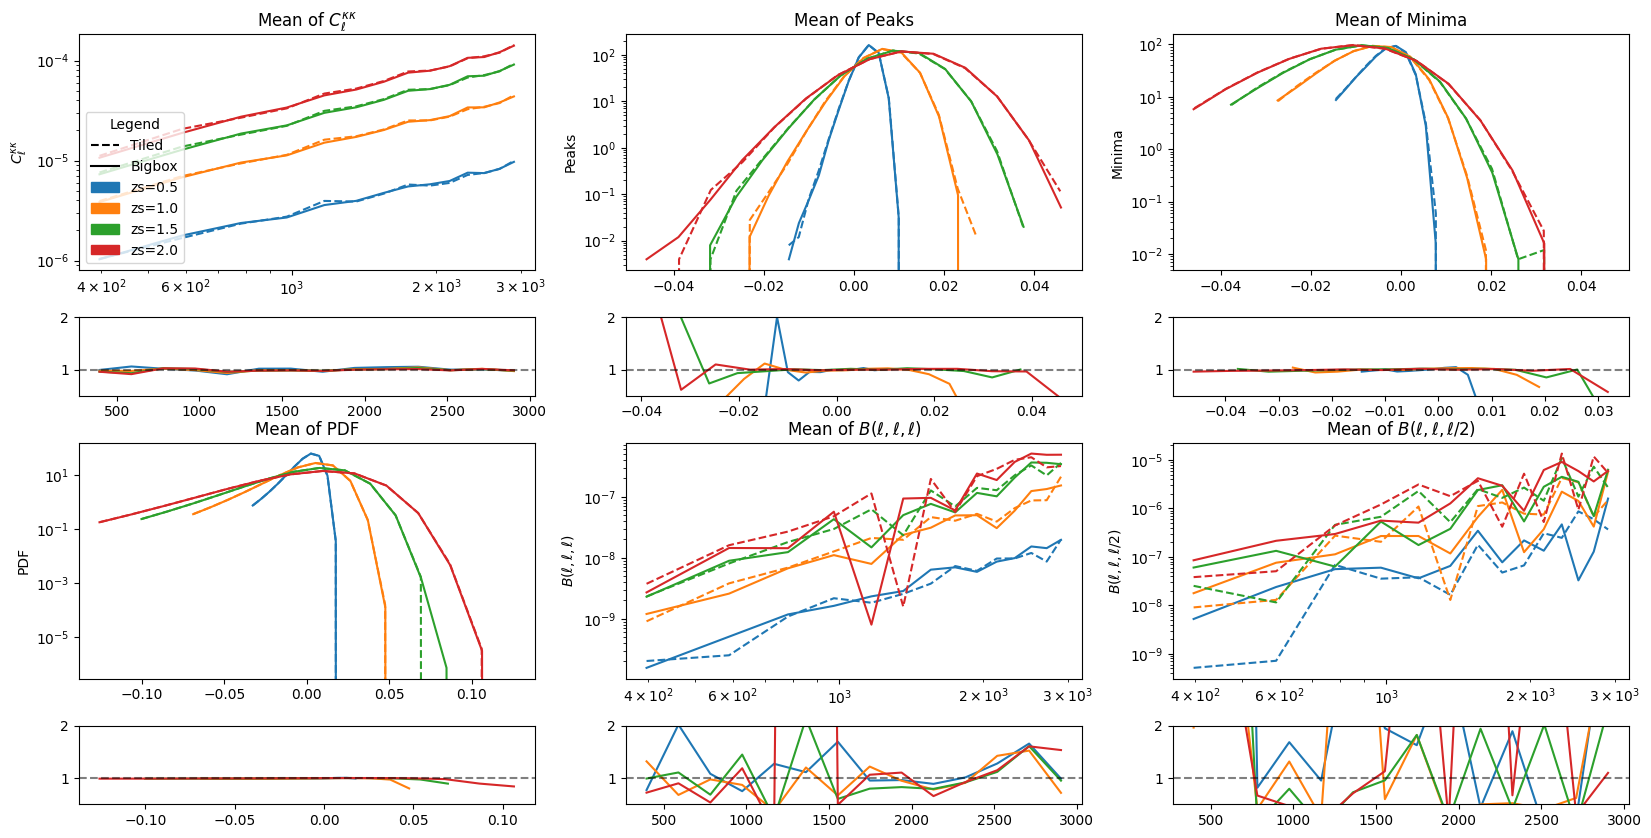

In [22]:
# Define colormap
cmap = plt.get_cmap("tab10")
colors = {zs: cmap(i) for i, zs in enumerate(zs_list)}

labels = [r'$C^{\kappa\kappa}_{\ell}$', 
          "Peaks",
          "Minima",
          "PDF",
          r'$B(\ell, \ell, \ell)$', 
          r'$B(\ell, \ell, \ell/2)$', 
          r'$B(\ell, \ell, \sim0)$']

# Define line styles
line_styles = {"tiled": "--", "bigbox": "-"}

binsize = 14

# Create the figure and GridSpec layout
# Create the figure and GridSpec layout
fig = plt.figure(figsize=(20, 10))
gs = GridSpec(4, 3, height_ratios=[3, 1, 3, 1], hspace=0.3)

axes = [fig.add_subplot(gs[0, i]) for i in range(3)] + [fig.add_subplot(gs[2, i]) for i in range(3)]
ratio_axes = [fig.add_subplot(gs[1, i]) for i in range(3)] + [fig.add_subplot(gs[3, i]) for i in range(3)]

for i, ax in enumerate(axes):
    for j, zs in enumerate(zs_list):
        ax.plot(bins_bigbox[j][i*binsize:(i+1)*binsize], np.abs(data_mean_bigbox[j][i*binsize:(i+1)*binsize]), color=colors[zs], label=f"zs={zs}", linestyle=line_styles["bigbox"])
        #ax.fill_between(bins_bigbox[j][i*binsize:(i+1)*binsize], np.abs(data_mean_bigbox[j][i*binsize:(i+1)*binsize] - data_std_bigbox[j][i*binsize:(i+1)*binsize]), np.abs(data_mean_bigbox[j][i*binsize:(i+1)*binsize] + data_std_bigbox[j][i*binsize:(i+1)*binsize]), color=colors[zs], alpha=0.1)
        ax.plot(bins_tiled[j][i*binsize:(i+1)*binsize], np.abs(data_mean_tiled[j][i*binsize:(i+1)*binsize]), color=colors[zs], label=f"zs={zs}", linestyle=line_styles["tiled"])
        #ax.fill_between(bins_tiled[j][i*binsize:(i+1)*binsize], np.abs(data_mean_tiled[j][i*binsize:(i+1)*binsize] - data_std_tiled[j][i*binsize:(i+1)*binsize]), np.abs(data_mean_tiled[j][i*binsize:(i+1)*binsize] + data_std_tiled[j][i*binsize:(i+1)*binsize]), color=colors[zs], alpha=0.1)

for i, ax in enumerate(ratio_axes):
    for j, zs in enumerate(zs_list):
        ax.plot(bins_bigbox[j][i*binsize:(i+1)*binsize], np.abs(data_mean_bigbox[j][i*binsize:(i+1)*binsize])/np.abs(data_mean_tiled[j][i*binsize:(i+1)*binsize]), color=colors[zs], label=f"zs={zs}", linestyle=line_styles["bigbox"])
    ax.axhline(1, color='black', linestyle="--", alpha=0.5)
    ax.set_ylim(0.5, 2)

# Set the axis labels
for i, ax, label in zip(range(len(axes)), axes, labels):
    ax.set_title(f"Mean of {label}")
    ax.set_ylabel(label)
    ax.set_xticklabels([])
    ax.set_yscale("log")
    ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
    ax.get_xaxis().set_minor_formatter(plt.NullFormatter())

# Set the axis ticks
axes[0].set_xscale("log")
#axes[0].set_xticks([300, 1000, 3000])

for ax in axes[4:]:
    ax.set_xscale("log")
    #ax.set_xticks([300, 1000, 3000])

# Custom legend handles
legend_handles = []

# Add handles for line styles
legend_handles.append(Line2D([0], [0], color='black', linestyle=line_styles["tiled"], label='Tiled'))
legend_handles.append(Line2D([0], [0], color='black', linestyle=line_styles["bigbox"], label='Bigbox'))

# Add handles for colors (redshifts)
for zs in zs_list:
    legend_handles.append(Patch(color=colors[zs], label=f"zs={zs}"))

# Place the legend in the first subplot
axes[0].legend(handles=legend_handles, title="Legend", loc='lower left')

# Save the figure
#plt.savefig(os.path.join(config_analysis.resultsdir, "correlation.pdf"), bbox_inches="tight")

plt.tight_layout()
plt.show()

## Plot Diagonal

/var/tmp/pbs.268106.idark/ipykernel_169072/2912464311.py:38: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(bins_bigbox[j][i*binsize:(i+1)*binsize], diagonal_terms_bigbox[j][i*binsize:(i+1)*binsize]/diagonal_terms_tiled[j][i*binsize:(i+1)*binsize], color=colors[zs], label=f"zs={zs}", linestyle=line_styles["bigbox"])
/var/tmp/pbs.268106.idark/ipykernel_169072/2912464311.py:38: RuntimeWarning: divide by zero encountered in true_divide
  ax.plot(bins_bigbox[j][i*binsize:(i+1)*binsize], diagonal_terms_bigbox[j][i*binsize:(i+1)*binsize]/diagonal_terms_tiled[j][i*binsize:(i+1)*binsize], color=colors[zs], label=f"zs={zs}", linestyle=line_styles["bigbox"])
/var/tmp/pbs.268106.idark/ipykernel_169072/2912464311.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


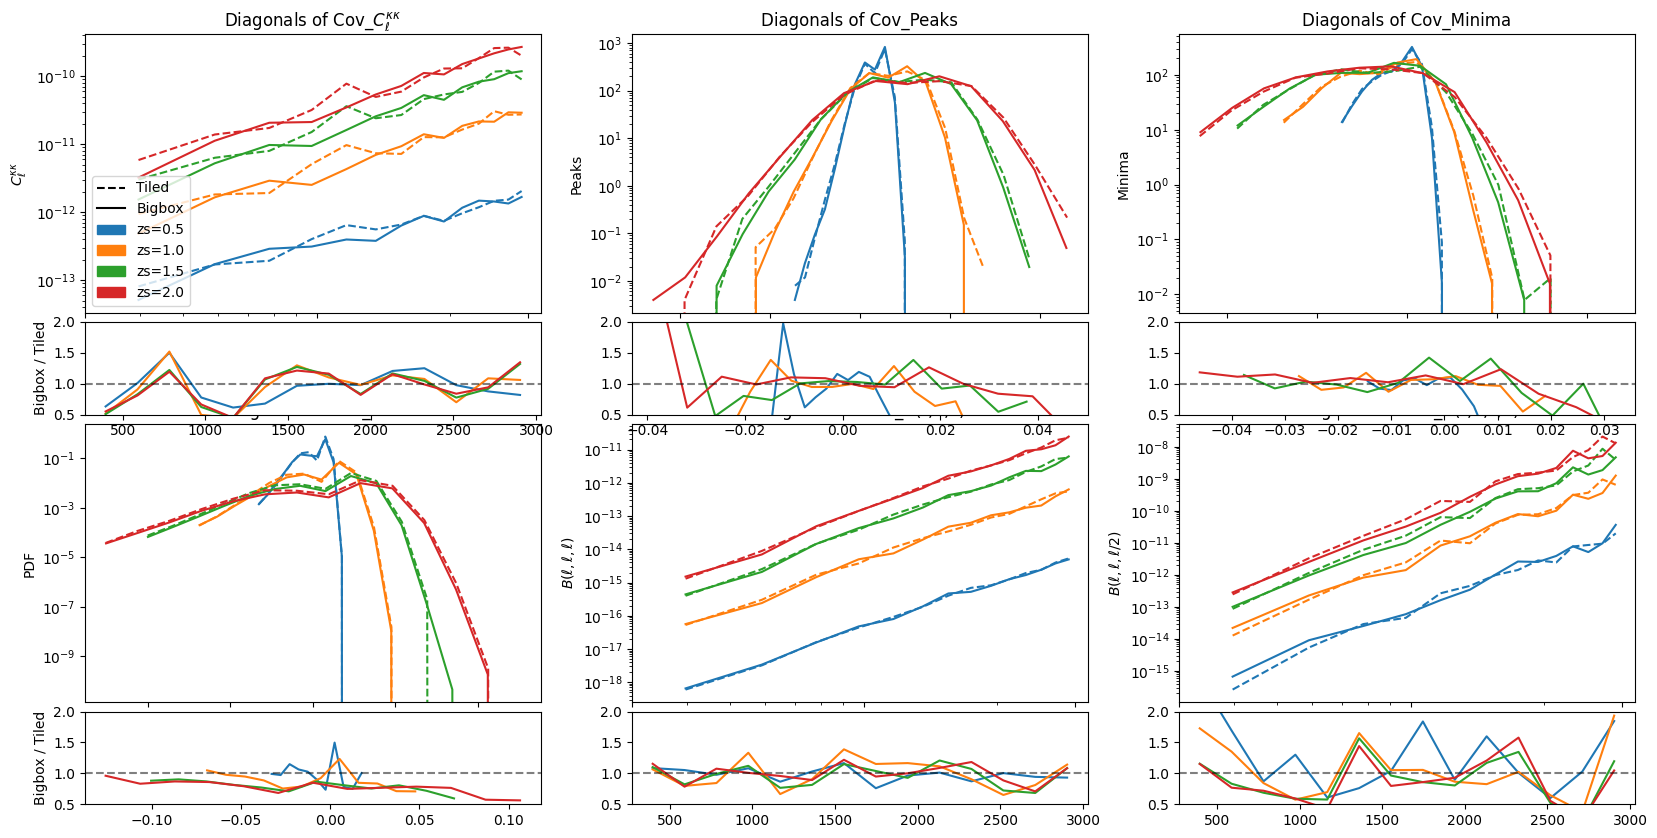

In [71]:
# Define colormap
cmap = plt.get_cmap("tab10")
colors = {zs: cmap(i) for i, zs in enumerate(zs_list)}

labels = [r'$C^{\kappa\kappa}_{\ell}$', 
          "Peaks",
          "Minima",
          "PDF",
          r'$B(\ell, \ell, \ell)$', 
          r'$B(\ell, \ell, \ell/2)$', 
          r'$B(\ell, \ell, \sim0)$']

# Define line styles
line_styles = {"tiled": "--", "bigbox": "-"}

# Create the figure and GridSpec layout
fig = plt.figure(figsize=(20, 10))
gs = GridSpec(4, 3, height_ratios=[3, 1, 3, 1], hspace=0.05)

axes = [fig.add_subplot(gs[0, i]) for i in range(3)] + [fig.add_subplot(gs[2, i]) for i in range(3)]
ratio_axes = [fig.add_subplot(gs[1, i]) for i in range(3)] + [fig.add_subplot(gs[3, i]) for i in range(3)]

binsize = 14

for i, ax in enumerate(axes):
    for j, zs in enumerate(zs_list):
        ax.plot(bins_bigbox[j][i*binsize:(i+1)*binsize], diagonal_terms_tiled[j][i*binsize:(i+1)*binsize], color=colors[zs], label=f"zs={zs}", linestyle=line_styles["tiled"])
        ax.plot(bins_tiled[j][i*binsize:(i+1)*binsize], diagonal_terms_bigbox[j][i*binsize:(i+1)*binsize], color=colors[zs], label=f"zs={zs}", linestyle=line_styles["bigbox"])
    ax.set_title(f"Diagonals of Cov_{labels[i]}")
    ax.set_ylabel(labels[i])
    ax.set_xticklabels([])
    ax.set_yscale("log")
    ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
    ax.get_xaxis().set_minor_formatter(plt.NullFormatter())

for i, ax in enumerate(ratio_axes):
    for j, zs in enumerate(zs_list):
        ax.plot(bins_bigbox[j][i*binsize:(i+1)*binsize], diagonal_terms_bigbox[j][i*binsize:(i+1)*binsize]/diagonal_terms_tiled[j][i*binsize:(i+1)*binsize], color=colors[zs], label=f"zs={zs}", linestyle=line_styles["bigbox"])
    ax.axhline(1, color='black', linestyle="--", alpha=0.5)
    ax.set_ylim(0.5, 2)

# Set the axis ticks
axes[0].set_xscale("log")
axes[0].set_xticks([300, 1000, 3000])

for ax in axes[4:]:
    ax.set_xscale("log")
    ax.set_xticks([300, 1000, 3000])

# Custom legend handles
legend_handles = []

# Add handles for line styles
legend_handles.append(Line2D([0], [0], color='black', linestyle=line_styles["tiled"], label='Tiled'))
legend_handles.append(Line2D([0], [0], color='black', linestyle=line_styles["bigbox"], label='Bigbox'))

# Add handles for colors (redshifts)
for zs in zs_list:
    legend_handles.append(Patch(color=colors[zs], label=f"zs={zs}"))

# Place the legend in the first subplot
axes[0].legend(handles=legend_handles, loc='lower left')

ratio_axes[0].set_ylabel("Bigbox / Tiled")
ratio_axes[3].set_ylabel("Bigbox / Tiled")

# Save the figure
#plt.savefig(os.path.join(config_analysis.resultsdir, "correlation.pdf"), bbox_inches="tight")

plt.tight_layout()
plt.show()